In [3]:
import os
import pandas as pd
import pyreadr
import geopandas as gpd

In [62]:
output_dir = r'C:\Workspace\VisionEval_build\VisionEval\built\visioneval\4.1.2\runtime\models\VERSPM\Datastore'

year = '2018'
def export_households(output_dir, year, scenario_name):

    hh_df = pd.DataFrame()
    hh_path = os.path.join(output_dir, year, 'Household')
    for fname in os.listdir(hh_path):
        result = pyreadr.read_r(os.path.join(hh_path, fname))
        hh_df[fname.split('.')[0]] = result['Dataset']['Dataset']
    hh_df['Scenario'] = scenario_name

    return hh_df

In [5]:
soundcast_dir = r'L:\RTP_2022\final_runs\sc_2018_rtp_final\soundcast\outputs\daysim'

# Load soundcast reslts for vehicles and drivers
daysim_hh = pd.read_csv(os.path.join(soundcast_dir,'_household.tsv'), delim_whitespace=True)
daysim_trip = pd.read_csv(os.path.join(soundcast_dir,'_trip.tsv'), delim_whitespace=True)
daysim_person = pd.read_csv(os.path.join(soundcast_dir,'_person.tsv'), delim_whitespace=True)

In [63]:

hh_df_base = export_households(output_dir, year='2018', scenario_name='2018')

In [64]:
# output_dir

In [65]:
pd.options.display.float_format = '{:0,.0f}'.format

In [66]:
def build_table(ve_arg, sc_arg):
    ve_val = pd.eval(ve_arg, engine='python')
    sc_val = pd.eval(sc_arg, engine='python')
    df = pd.DataFrame([ve_val,sc_val]).T
    df.columns = ['VisionEval', 'Soundcast']
    # df.fillna(-1, inplace=True)
    df['Diff'] = df['VisionEval']-df['Soundcast']
    df['% Diff'] = (df['Diff']/df['Soundcast'])
    df[['% Diff']] = df[['% Diff']].applymap("{:,.1%}".format)

    return df

In [67]:
hh_df_base.columns

Index(['Age0to14', 'Age15to19', 'Age20to29', 'Age30to54', 'Age55to64',
       'Age65Plus', 'AveCO2ePM', 'AveGPM', 'AveKWHPM', 'AveRoadUseTaxPM',
       'AveSocEnvCostPM', 'AveTrpLenDiverted', 'AveVehCostPM', 'AveVehTripLen',
       'Azone', 'BikeTrips', 'Bzone', 'CarSvcLevel', 'DailyCO2e', 'DailyGGE',
       'DailyKWH', 'Drivers', 'Drv15to19', 'Drv20to29', 'Drv30to54',
       'Drv55to64', 'Drv65Plus', 'DrvAgePersons', 'Dvmt', 'FreeParkingSpaces',
       'HasPaydIns', 'HhId', 'HhSize', 'HhType', 'HouseType', 'Income',
       'IsEcoDrive', 'IsIMP', 'IsUrbanMixNbrhd', 'LifeCycle', 'LocType',
       'Marea', 'NumAuto', 'NumHighCarSvc', 'NumLtTrk', 'OtherParkingCost',
       'OwnCost', 'OwnCostSavings', 'ParkingUnitCost', 'PropDvmtDiverted',
       'PropTdmDvmtReduction', 'SovDvmtProp', 'TransitTrips', 'UrbanDvmtProp',
       'Vehicles', 'VehicleTrips', 'WalkTrips', 'Wkr15to19', 'Wkr20to29',
       'Wkr30to54', 'Wkr55to64', 'Wkr65Plus', 'Workers', 'Scenario'],
      dtype='object')

# Vehicle Ownership

In [68]:
build_table("hh_df_base['Vehicles'].sum()", "daysim_hh['hhvehs'].sum()")

,VisionEval,Soundcast,Diff,% Diff
0,"3,522,728","3,069,100","453,628",14.8%


In [69]:
build_table("hh_df_base.groupby('Vehicles').count()['Age0to14']", "daysim_hh.groupby('hhvehs').sum()['hhexpfac']")

,VisionEval,Soundcast,Diff,% Diff
0,NaN,"106,565",NaN,nan%
1,"455,024","486,738","-31,714",-6.5%
2,"612,428","584,187","28,241",4.8%
3,"362,250","297,104","65,146",21.9%
4,"136,171","130,669","5,502",4.2%
5,"32,852",NaN,NaN,nan%
6,"6,162",NaN,NaN,nan%
7,735,NaN,NaN,nan%
8,192,NaN,NaN,nan%
9,389,NaN,NaN,nan%


# Household Composition

In [70]:
pd.options.display.float_format = '{:0,.2f}'.format
build_table("hh_df_base['HhSize'].mean()", "daysim_hh['hhsize'].mean()")

,VisionEval,Soundcast,Diff,% Diff
0,2.52,2.52,-0.00,-0.1%


In [71]:
# Create categories for daysim by age
age_bins = [-1, 15, 20, 30, 55, 65, 200]
age_labels = ['Age0to14','Age15to19','Age20to29','Age30to54','Age55to64','Age65Plus']
daysim_person['age_group'] = pd.cut(daysim_person['pagey'], age_bins, labels=age_labels)
df = daysim_person.groupby('age_group').sum()[['psexpfac']]

In [72]:
build_table("hh_df_base[age_labels].sum()", "df['psexpfac']")


,VisionEval,Soundcast,Diff,% Diff
Age0to14,"689,370.00","738,213.00","-48,843.00",-6.6%
Age15to19,"261,890.00","258,374.00","3,516.00",1.4%
Age20to29,"553,679.00","572,952.00","-19,273.00",-3.4%
Age30to54,"1,402,819.00","1,399,930.00","2,889.00",0.2%
Age55to64,"572,932.00","558,953.00","13,979.00",2.5%
Age65Plus,"572,402.00","524,732.00","47,670.00",9.1%


## Workers

In [73]:
build_table("hh_df_base['Workers'].sum()", "daysim_person[daysim_person['pwtyp'] > 0]['psexpfac'].sum()")


,VisionEval,Soundcast,Diff,% Diff
0,"1,950,188.00","1,982,128.00","-31,940.00",-1.6%


In [74]:
# Workers by Age
worker_age_group = ['15to19', '20to29','30to54', '55to64', '65Plus']
worker_cols = ['Wkr'+i for i in worker_age_group]
df = hh_df_base[worker_cols].sum()
df.index = worker_age_group

df_sc = daysim_person[daysim_person['pwtyp'] >0].groupby('age_group').sum()['psexpfac']
df_sc.drop('Age0to14', inplace=True)
df_sc.index = worker_age_group

build_table("df","df_sc")

,VisionEval,Soundcast,Diff,% Diff
15to19,"55,620.00","65,953.00","-10,333.00",-15.7%
20to29,"382,781.00","422,307.00","-39,526.00",-9.4%
30to54,"1,051,579.00","1,086,230.00","-34,651.00",-3.2%
55to64,"360,372.00","329,537.00","30,835.00",9.4%
65Plus,"99,836.00","78,101.00","21,735.00",27.8%


## Income

In [75]:
# Mean Income
build_table("hh_df_base['Income'].mean()","daysim_hh['hhincome'].mean()")

,VisionEval,Soundcast,Diff,% Diff
0,"106,933.18","107,071.37",-138.19,-0.1%


In [76]:
# Median Income
build_table("hh_df_base['Income'].mean()","daysim_hh['hhincome'].median()")

,VisionEval,Soundcast,Diff,% Diff
0,"106,933.18","82,000.00","24,933.18",30.4%


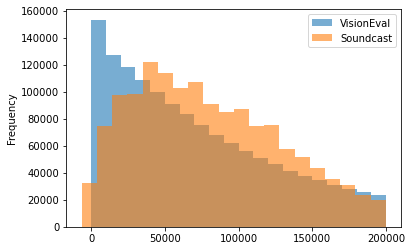

In [77]:
%matplotlib inline
ax= hh_df_base[hh_df_base['Income'] < 200000]['Income'].plot(kind='hist', bins=20,  alpha=0.6, legend=True)
daysim_hh[daysim_hh['hhincome'] < 200000]['hhincome'].plot(kind='hist', bins=20, ax=ax, alpha=0.6, legend=True)
ax.legend(labels=['VisionEval','Soundcast'])
# plt.legend,'test2

In [78]:
hh_df_base['Dvmt'].sum()

78954868.74608612